In [1]:
# ✅ RL-Driven Difficulty Estimator (PPO Curriculum)
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from transformers import AutoTokenizer, AutoModel
from models import SimpleClassifier, DifficultyEstimator
import torch.nn.functional as F

In [2]:
# ----------------------------------------
# ✅ Custom Curriculum Environment
# ----------------------------------------
class CurriculumEnv(gym.Env):
    def __init__(self, embeddings, labels, device):
        super().__init__()
        self.embeddings = embeddings
        self.labels = labels
        self.device = device

        self.classifier = SimpleClassifier().to(device)
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-4)

        self.n_samples = len(embeddings)
        self.max_steps = 1000
        self.step_count = 0

        self.action_space = gym.spaces.Discrete(self.n_samples)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)  # [progress, last_loss, avg_confidence]

        self.last_loss = 1.0
        self.total_reward = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.classifier = SimpleClassifier().to(self.device)
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-4)
        self.step_count = 0
        self.total_reward = 0
        self.last_loss = 1.0
        return self._get_obs(), {}

    def _get_obs(self):
    # Clamp loss and confidence to [0, 1] range for observation space
        scaled_loss = min(self.last_loss, 1.0)
        return np.array([
            self.step_count / self.max_steps,  # already in [0, 1]
            scaled_loss,
            np.random.rand()  # fake avg confidence
        ], dtype=np.float32)

    def step(self, action):
        idx = int(action)
        x = self.embeddings[idx].unsqueeze(0).to(self.device)
        y = self.labels[idx].unsqueeze(0).to(self.device)

        self.classifier.eval()
        with torch.no_grad():
            loss_before = F.cross_entropy(self.classifier(x), y).item()

        self.classifier.train()
        self.optimizer.zero_grad()
        loss = F.cross_entropy(self.classifier(x), y)
        loss.backward()
        self.optimizer.step()

        self.classifier.eval()
        with torch.no_grad():
            loss_after = F.cross_entropy(self.classifier(x), y).item()

        reward = (loss_before - loss_after) * 10
        self.last_loss = loss_after
        self.total_reward += reward

        self.step_count += 1
        done = self.step_count >= self.max_steps

        return self._get_obs(), reward, done, False, {}

    def render(self):
        print(f"Step {self.step_count}, Total Reward: {self.total_reward:.4f}")

In [15]:
# ----------------------------------------
# ✅ Train PPO Agent to Select Training Samples
# ----------------------------------------
def train_rl_estimator():
    data = np.load("bert_embeddings_train.npz")
    X = torch.tensor(data["embeddings"], dtype=torch.float32)
    y = torch.tensor(data["labels"], dtype=torch.long)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = CurriculumEnv(X, y, device)
    check_env(env, warn=True)

    model = PPO("MlpPolicy", env, verbose=1, batch_size=64, n_steps=2048)
    model.learn(total_timesteps=100000)

    # --- Phase 1: Run agent to log training behavior ---
    sample_log = []
    for ep in range(100):
        obs, _ = env.reset()
        for step in range(env.max_steps):
            action, _ = model.predict(obs, deterministic=False)
            sample_log.append((action, step))

            # Optionally: stochastic early reset
            if np.random.rand() < 0.01:
                obs, _ = env.reset()
            else:
                obs, _, done, _, _ = env.step(action)
                if done:
                    break

    # --- Phase 2: Convert logs into difficulty scores ---
    n_samples = len(X)
    difficulty_labels = np.zeros(n_samples)
    counts = np.zeros(n_samples)

    for idx, step in sample_log:
        #difficulty_labels[idx] += np.exp(-step / 100.0)
        difficulty_labels[idx] += step
        counts[idx] += 1

    difficulty_scores = difficulty_labels / (counts + 1e-8)
    #difficulty_scores = np.clip(difficulty_scores, 0, 1)
    difficulty_scores = (difficulty_scores - difficulty_scores.min()) / (difficulty_scores.max() - difficulty_scores.min())
    difficulty_scores = np.clip(difficulty_scores, 0, 1)

    # --- Phase 3: Train difficulty regressor ---
    estimator = DifficultyEstimator().to(device)
    optimizer = torch.optim.Adam(estimator.parameters(), lr=1e-4)

    target_scores = torch.tensor(difficulty_scores, dtype=torch.float32).unsqueeze(1).to(device)

    for epoch in range(10):
        perm = torch.randperm(len(X))
        for i in range(0, len(X), 32):
            idx = perm[i:i+32]
            xb = X[idx].to(device)
            yb = target_scores[idx]
            pred = torch.sigmoid(estimator(xb))
            loss = F.mse_loss(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

    # --- Phase 4: Save difficulty scores and model ---
    estimator.eval()
    with torch.no_grad():
        logits = estimator(X.to(device)).squeeze()
        scores = torch.sigmoid(logits).cpu().numpy()

    np.savez("difficulty_scores_rl.npz", difficulties=scores)
    torch.save(estimator.state_dict(), "rl_trained_estimator.pth")


In [16]:
train_rl_estimator()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 82.4     |
| time/              |          |
|    fps             | 193      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1e+03      |
|    ep_rew_mean          | 79.2       |
| time/                   |            |
|    fps                  | 177        |
|    iterations           | 2          |
|    time_elapsed         | 23         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03687193 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.2        |
|    entropy_loss         | -10.

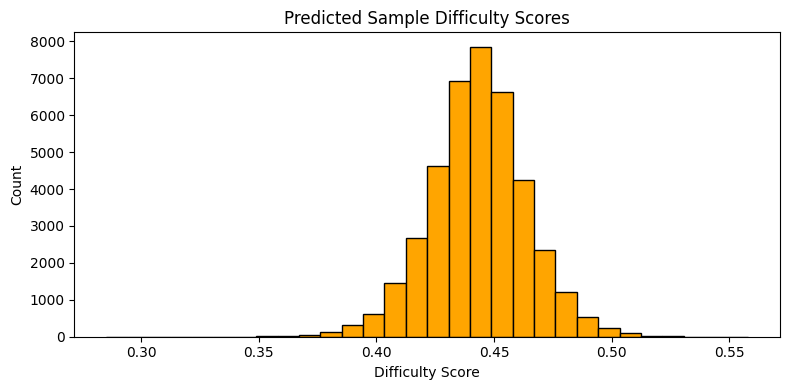

In [17]:
# 📈 Plot and save histogram
import matplotlib.pyplot as plt

# Load scores
data = np.load("difficulty_scores_rl.npz")
scores = data["difficulties"]

plt.figure(figsize=(8, 4))
plt.hist(scores, bins=30, color='orange', edgecolor='black')
plt.title("Predicted Sample Difficulty Scores")
plt.xlabel("Difficulty Score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("difficulty_histogram.png")
plt.show()

In [18]:
print(scores.min())
print(scores.max())

0.28525057
0.5579428
